# 基于 mesh 上的 uncore llc 计数 的实时内存带宽测量



In [3]:
perf_raw_path = '../data/csv/llc_uncore/500.perlbench_r_iter0_1744863898.csv'

## 单个文件的处理

从 `perf stat` 输出的 CSV 文件中提取数据，形成数据表

- timestamp 时间戳，每秒一次
- event 事件名
- value 事件计数值

In [5]:
import pandas as pd
import numpy as np

perf_raw_data = pd.read_csv(perf_raw_path,
                            sep='|',
                            header=None, 
                            names=["timestamp", "value", "event"], 
                            usecols=[0, 1, 3])

perf_raw_data

,timestamp,value,event
0,1.001062,523644029,arm_cmn_0/hnf_cache_miss/
1,1.001062,427543808,arm_cmn_1/hnf_cache_miss/
2,2.002472,362450646,arm_cmn_0/hnf_cache_miss/
3,2.002472,296798821,arm_cmn_1/hnf_cache_miss/
4,3.003810,473943542,arm_cmn_0/hnf_cache_miss/
...,...,...,...
447,224.298653,352019104,arm_cmn_1/hnf_cache_miss/
448,225.300065,30152488,arm_cmn_0/hnf_cache_miss/
449,225.300065,189387068,arm_cmn_1/hnf_cache_miss/
450,225.398993,2341122,arm_cmn_0/hnf_cache_miss/


统计每个socket上的hnf_cache_miss事件计数

In [ ]:
# perf_raw_data['type'] = perf_raw_data['event'].apply(
#     lambda x: 'reqs' if 'reqs'in x else 'retries'
# )
perf_raw_data['socket'] = perf_raw_data['event'].apply(
    lambda x: 0 if x[8] == '0' else '1'
)

perf_raw_data = perf_raw_data.drop('event', axis=1)
perf_raw_data

,timestamp,value,type,socket
0,1.001181,729098119,reqs,0
1,1.001181,5272703,retries,0
2,1.001181,689359911,reqs,1
3,1.001181,2809111,retries,1
4,2.002749,398406482,reqs,0
...,...,...,...,...
883,221.294702,735,retries,1
884,221.739469,184461899,reqs,0
885,221.739469,313,retries,0
886,221.739469,118470892,reqs,1


## 分析

系统整体带宽
先把 retries 的 value 变成负的，然后聚合就相当于是reqs减去retries了。

对每个时间戳，value 乘以 64 再除以时间

【推测】这里一次的数据量应该是 64 bits

In [7]:
perf_raw_data.loc[perf_raw_data["type"] == "retries", "value"] *= -1
perf_raw_data

,timestamp,value,type,socket
0,1.001181,729098119,reqs,0
1,1.001181,-5272703,retries,0
2,1.001181,689359911,reqs,1
3,1.001181,-2809111,retries,1
4,2.002749,398406482,reqs,0
...,...,...,...,...
883,221.294702,-735,retries,1
884,221.739469,184461899,reqs,0
885,221.739469,-313,retries,0
886,221.739469,118470892,reqs,1


In [8]:

bw_all = perf_raw_data.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()

bw_all['interval'] = bw_all['timestamp'].diff()
bw_all.loc[0, 'interval'] = bw_all.loc[0, 'timestamp']

bw_all['memory bandwidth (GB/s)'] = (bw_all['value'] * 64) / (bw_all['interval'] * 1000000000)

bw_all

,timestamp,value,interval,memory bandwidth (GB/s)
0,1.001181,1410376216,1.001181,90.157614
1,2.002749,814647263,1.001568,52.055796
2,3.004216,934485649,1.001467,59.719452
3,4.005224,878536251,1.001008,56.169693
4,5.006662,810742195,1.001437,51.813026
...,...,...,...,...
217,218.290676,847725623,1.001444,54.176194
218,219.292138,962481969,1.001462,61.508903
219,220.293253,1008694855,1.001115,64.484575
220,221.294702,734189041,1.001449,46.920107


绘制实时带宽曲线

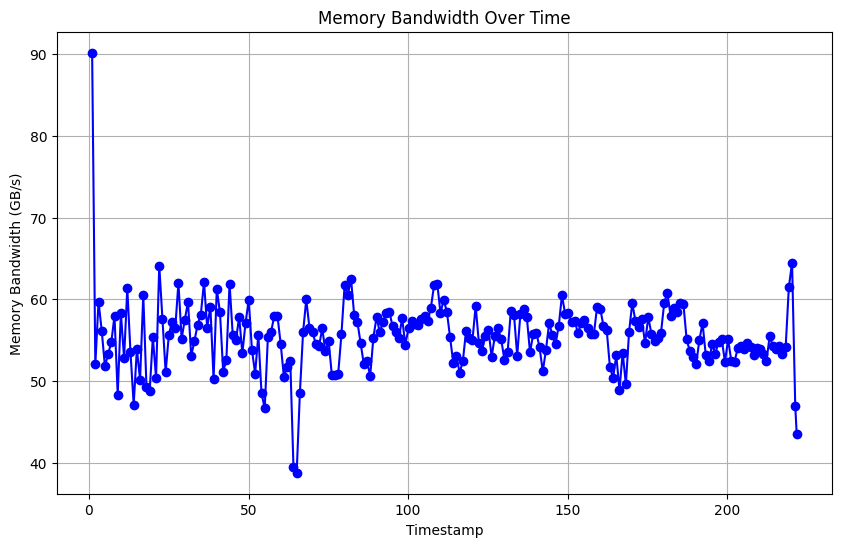

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(bw_all['timestamp'], bw_all['memory bandwidth (GB/s)'], marker='o', linestyle='-', color='b')
plt.title('Memory Bandwidth Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Memory Bandwidth (GB/s)')
plt.grid(True)
# plt.savefig('./data/images/memory_bandwidth.png')
plt.show()


## 批处理

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Set the path to the directory containing the CSV files
csv_dir = "../data/csv/cmn_mc/"

In [ ]:
# List all CSV files in the directory
files = os.listdir(csv_dir)
print(files)

['500.perlbench_r_iter0_1732727231.csv', '500.perlbench_r_iter0_1732727453.csv', '500.perlbench_r_iter0_1732727561.csv', '502.gcc_r_iter0_1732730115.csv', '502.gcc_r_iter0_1732730201.csv', '502.gcc_r_iter0_1732730308.csv', '502.gcc_r_iter0_1732730427.csv', '502.gcc_r_iter0_1732730562.csv', '503.bwaves_r_iter0_1732758224.csv', '503.bwaves_r_iter0_1732758672.csv', '503.bwaves_r_iter0_1732759320.csv', '503.bwaves_r_iter0_1732759830.csv', '505.mcf_r_iter0_1732734283.csv', '507.cactuBSSN_r_iter0_1732763763.csv', '508.namd_r_iter0_1732765498.csv', '510.parest_r_iter0_1732770298.csv', '511.povray_r_iter0_1732775545.csv', '519.lbm_r_iter0_1732781328.csv', '520.omnetpp_r_iter0_1732739475.csv', '521.wrf_r_iter0_1732789542.csv', '523.xalancbmk_r_iter0_1732743238.csv', '525.x264_r_iter0_1732745202.csv', '525.x264_r_iter0_1732745249.csv', '525.x264_r_iter0_1732745373.csv', '526.blender_r_iter0_1732793389.csv', '527.cam4_r_iter0_1732795664.csv', '531.deepsjeng_r_iter0_1732746710.csv', '538.imagick_r

C:\Users\ERQI\AppData\Local\Temp\ipykernel_20864\1300516116.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


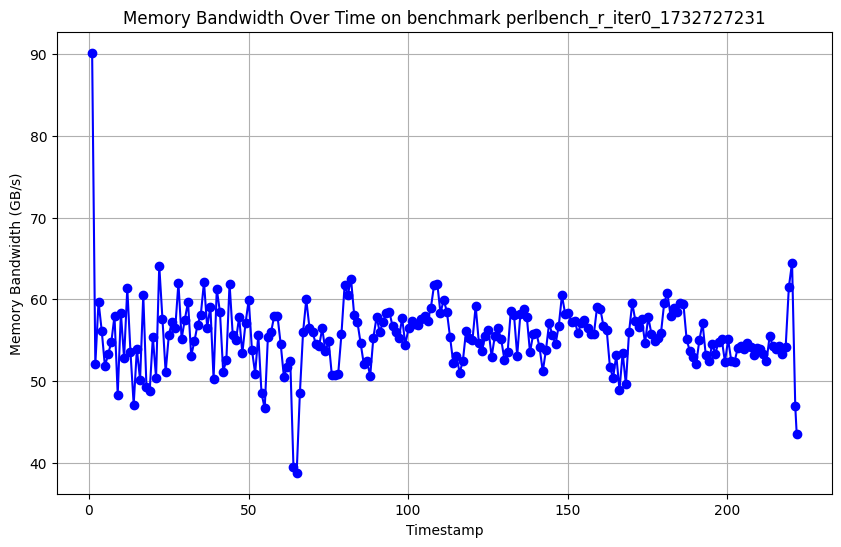

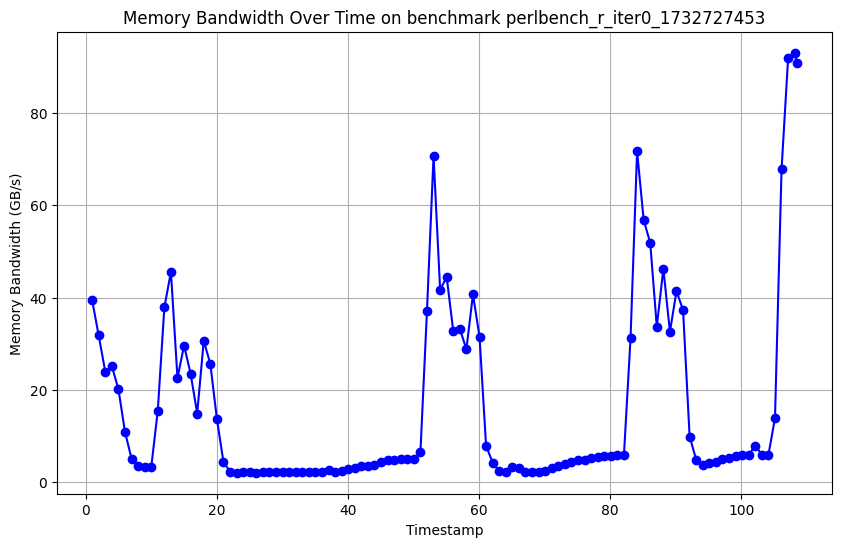

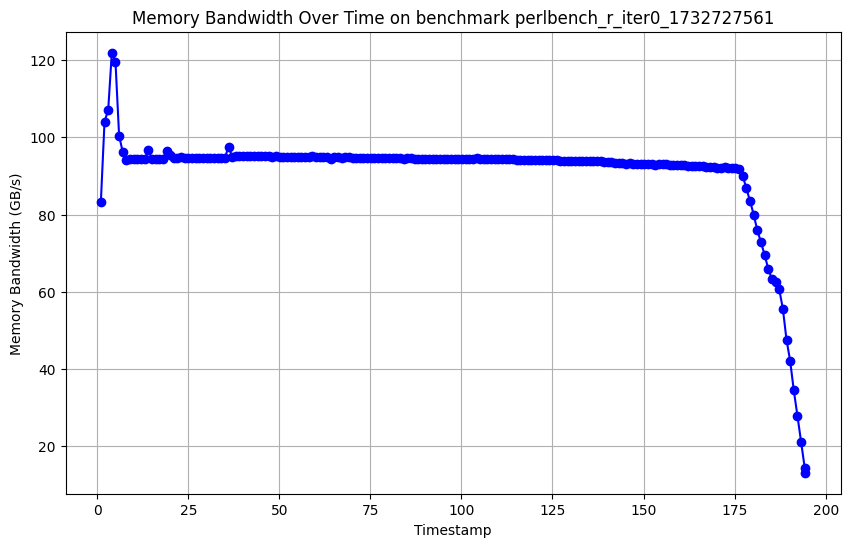

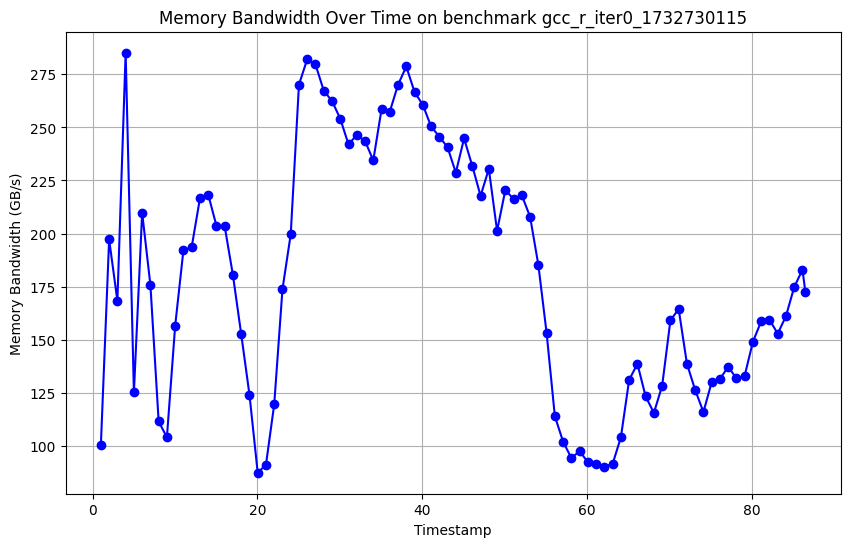

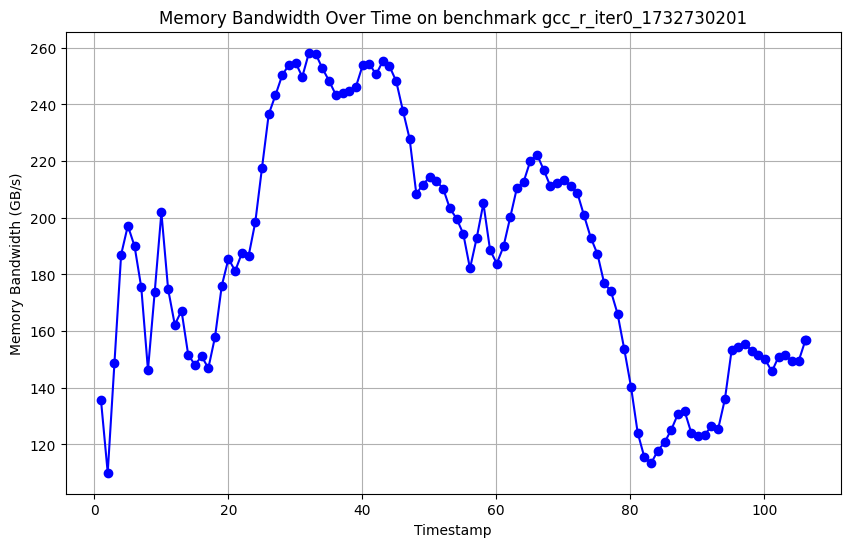

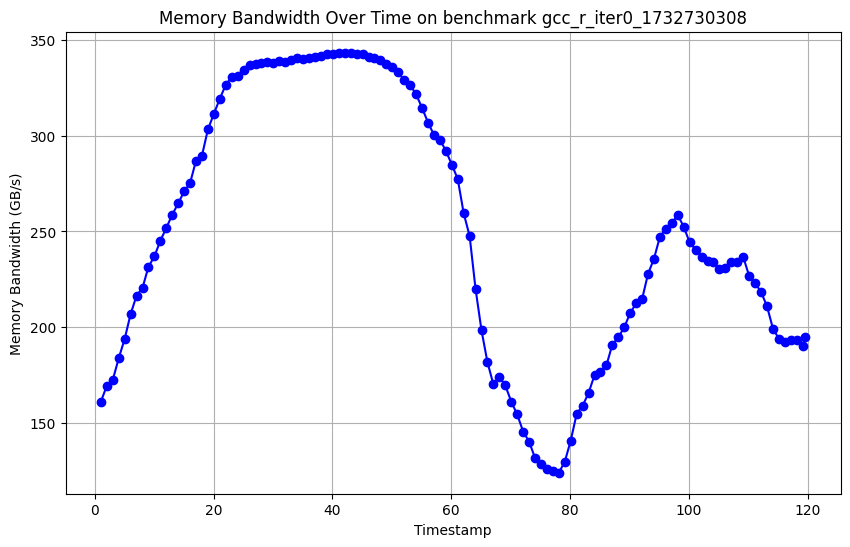

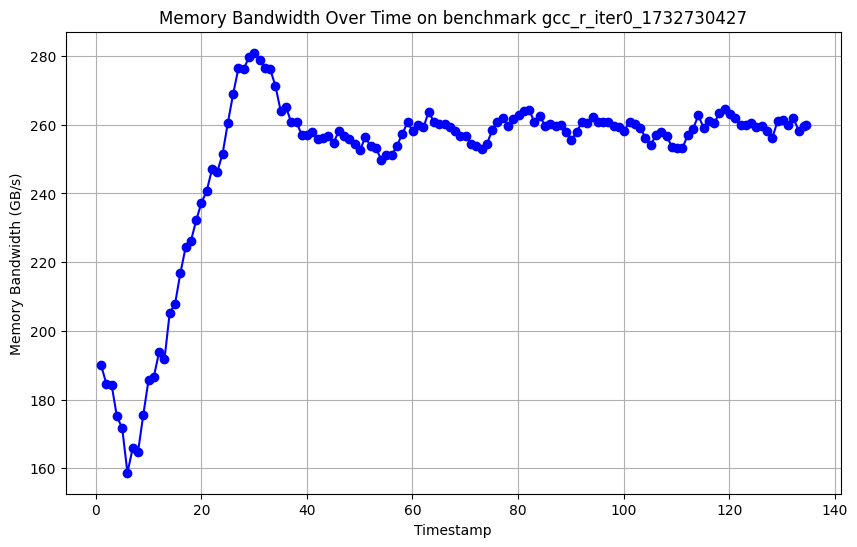

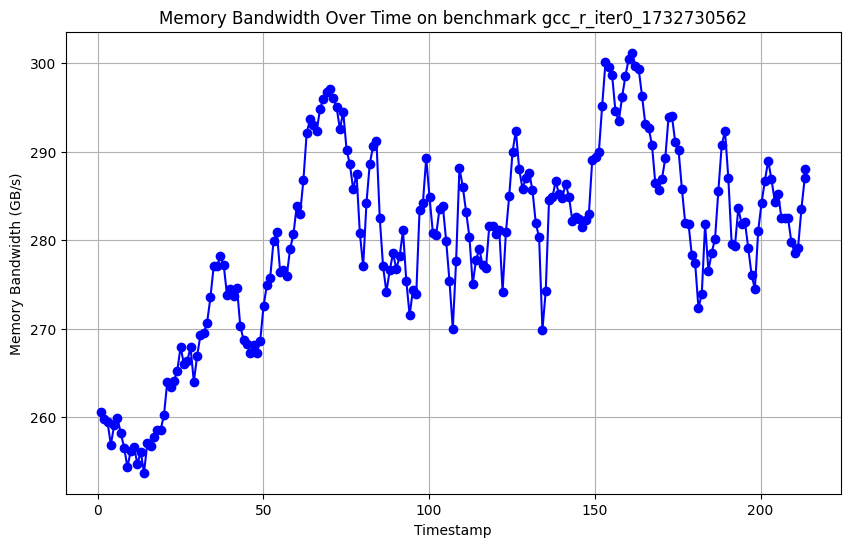

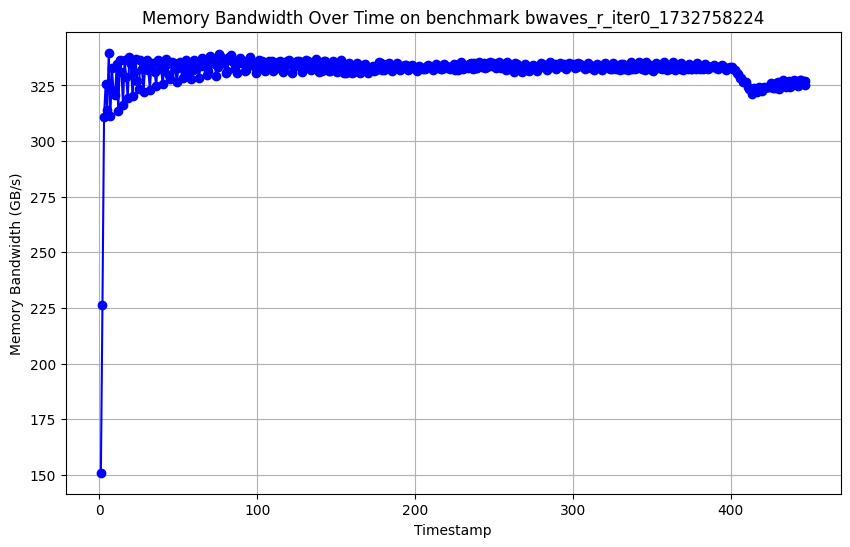

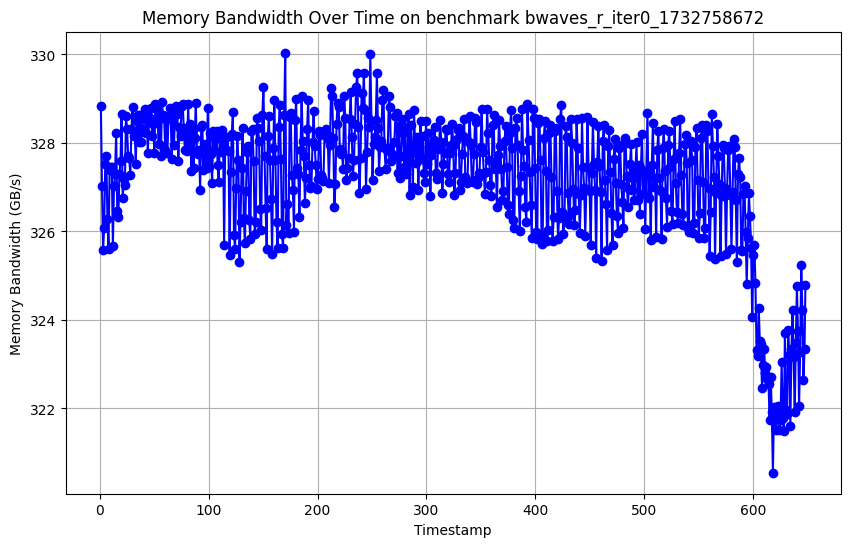

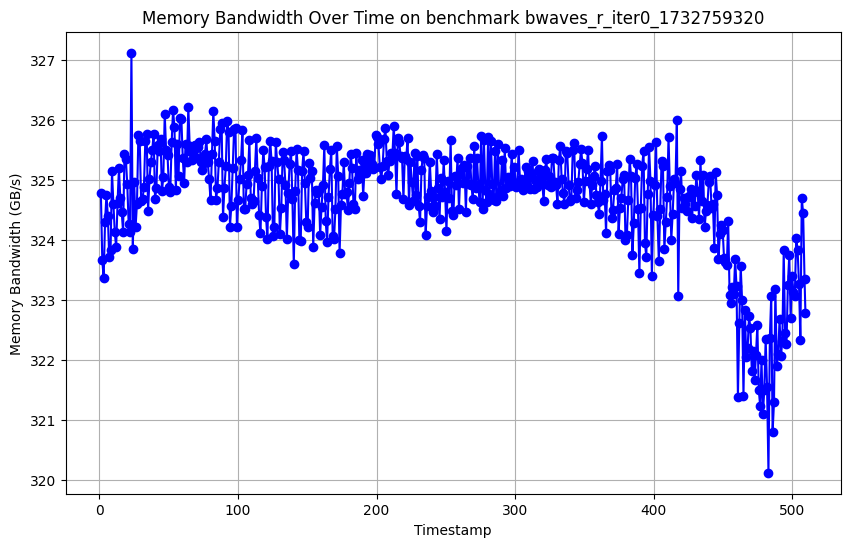

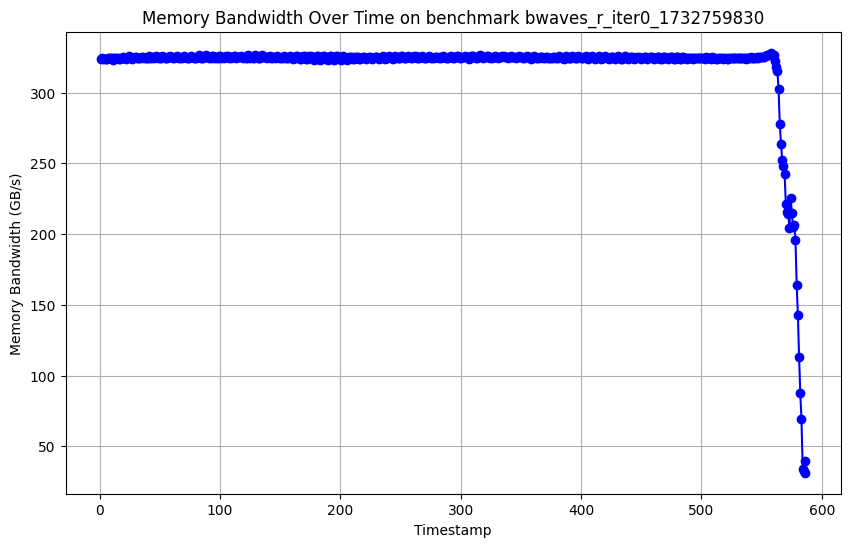

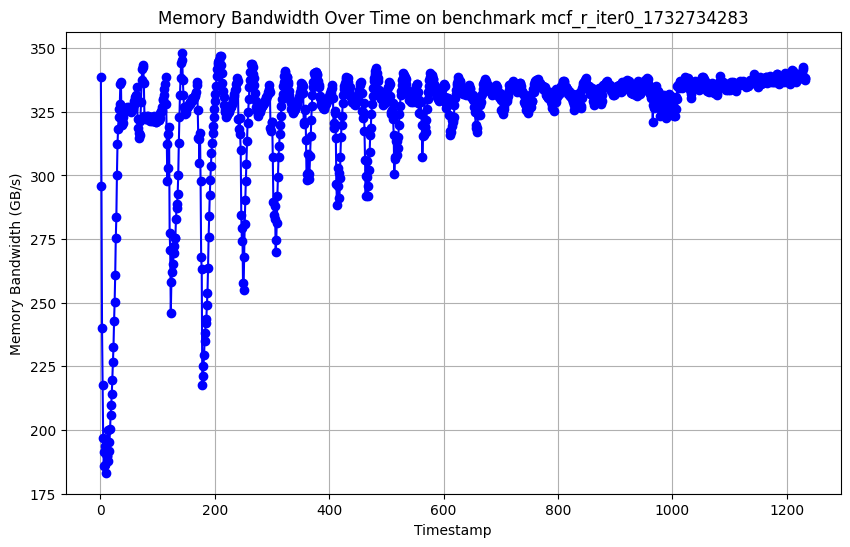

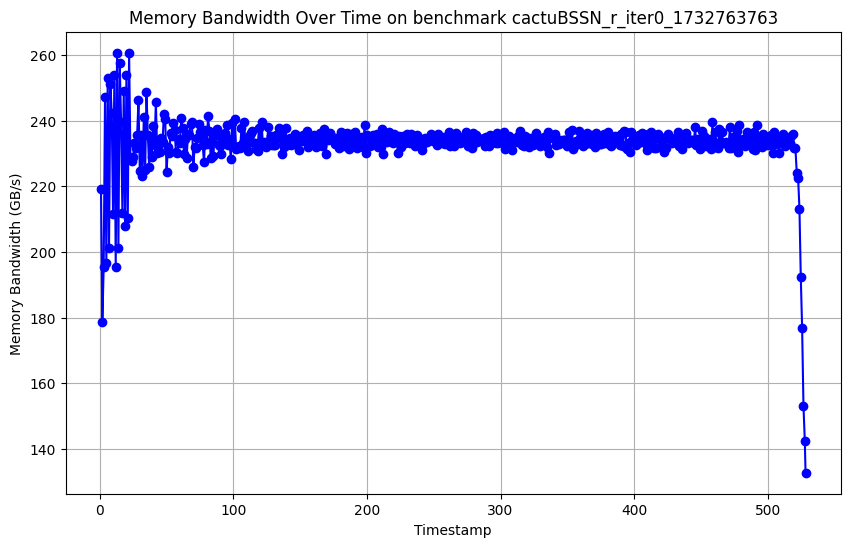

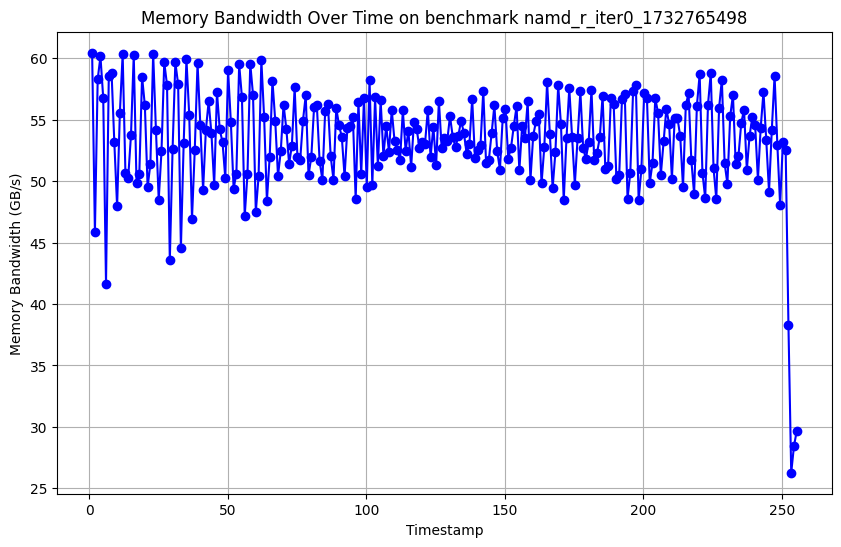

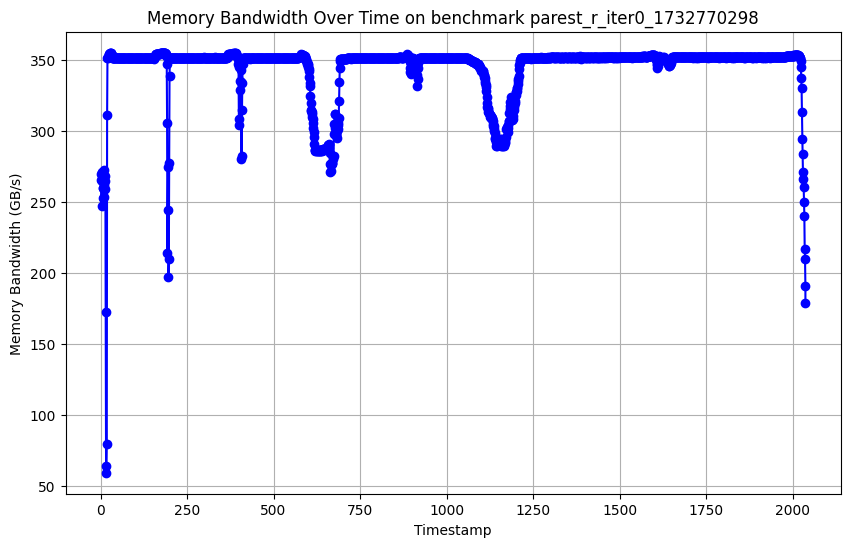

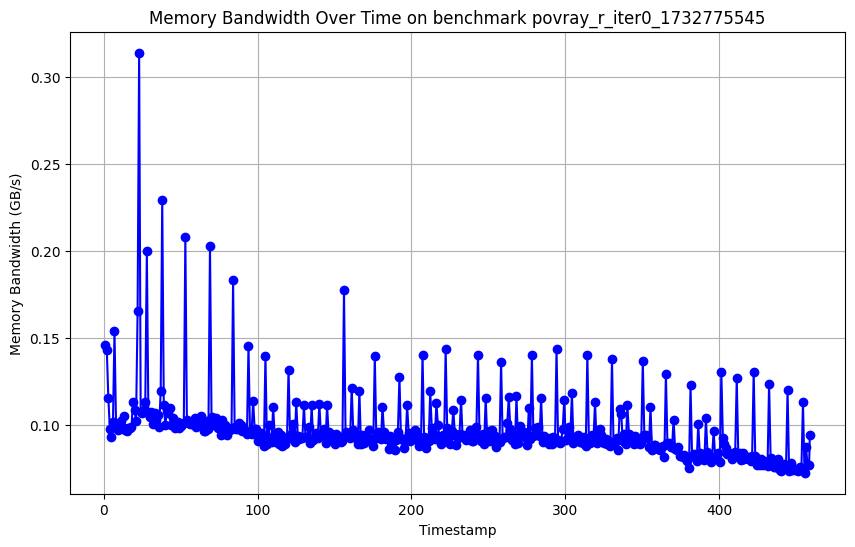

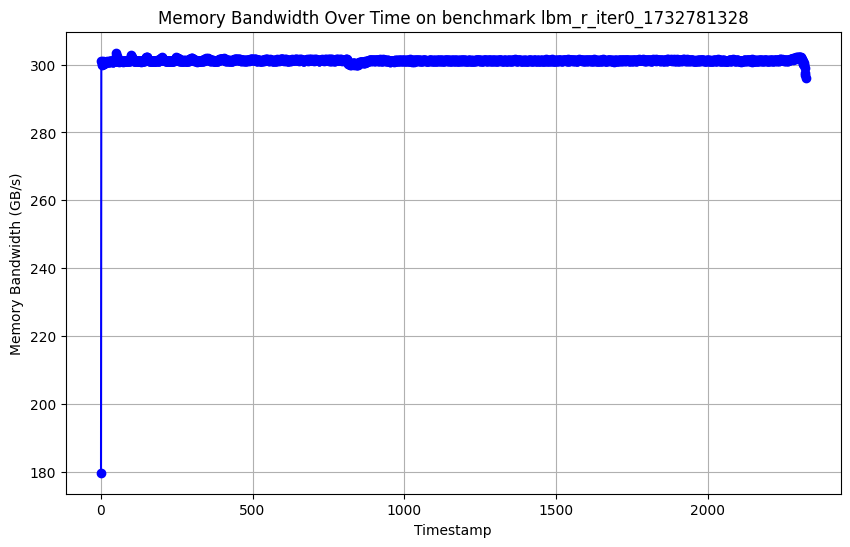

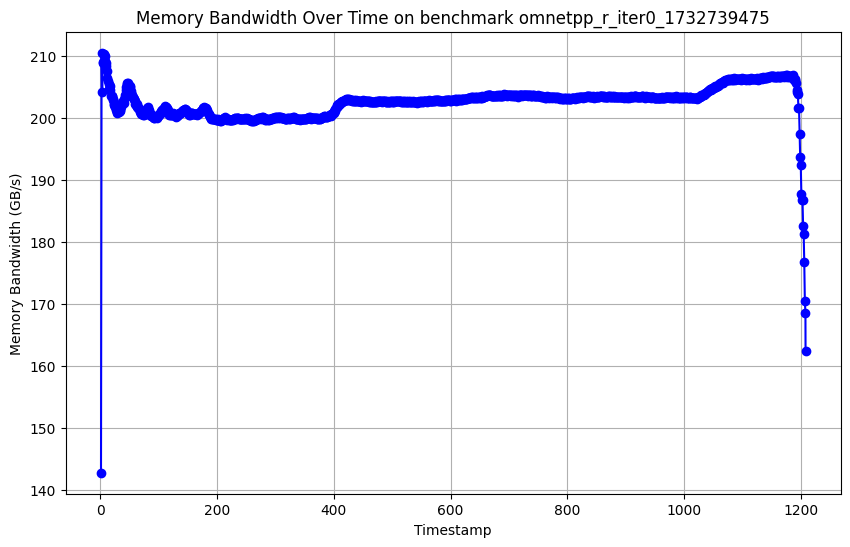

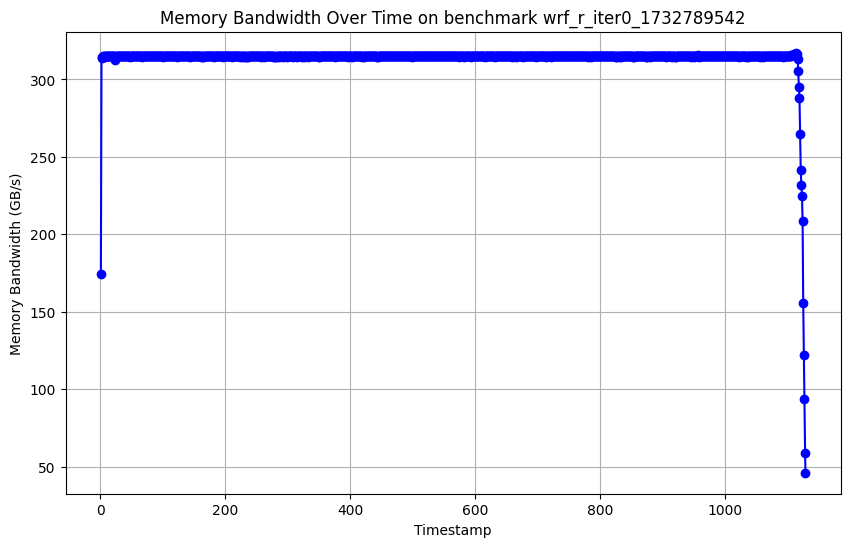

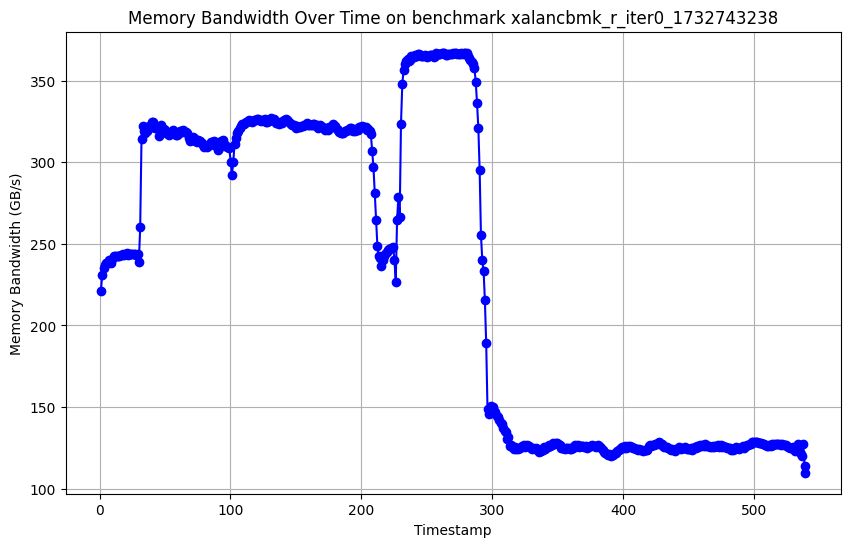

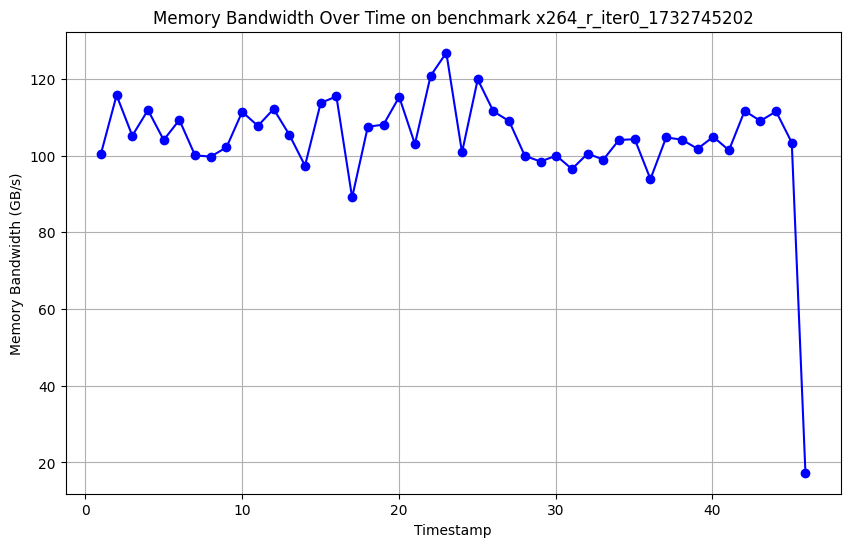

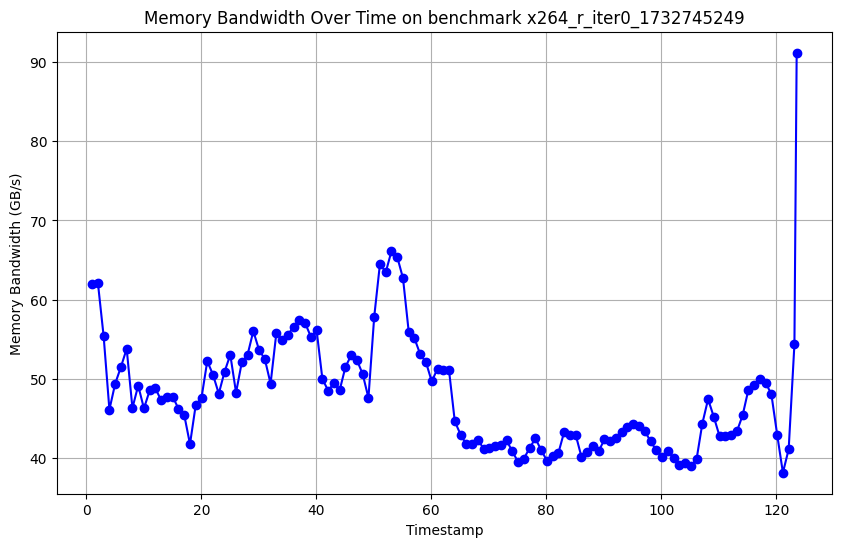

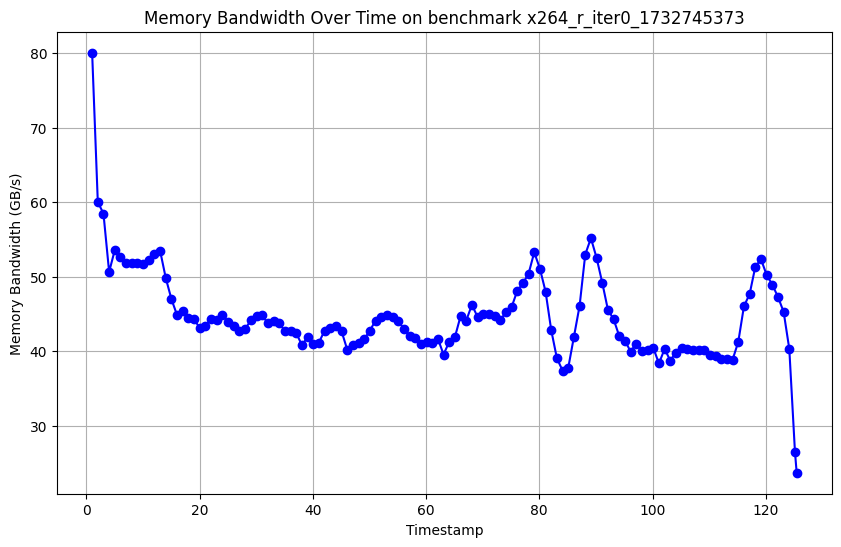

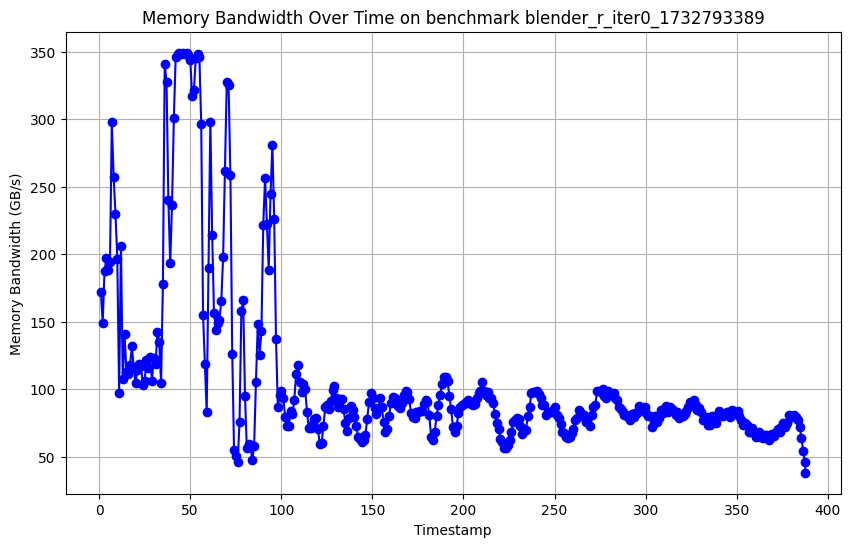

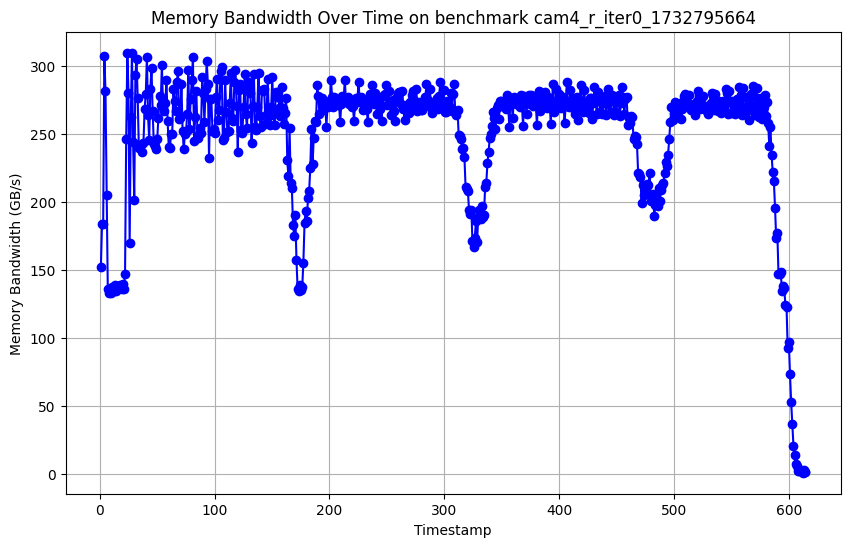

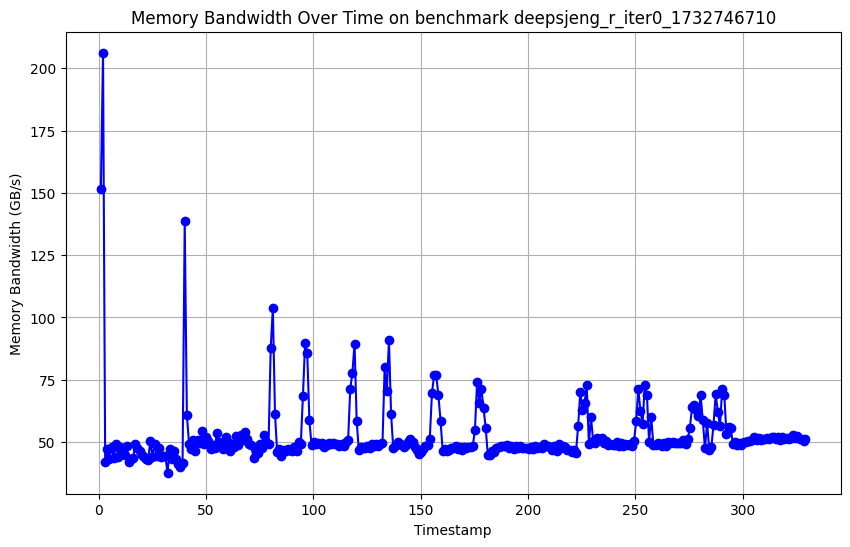

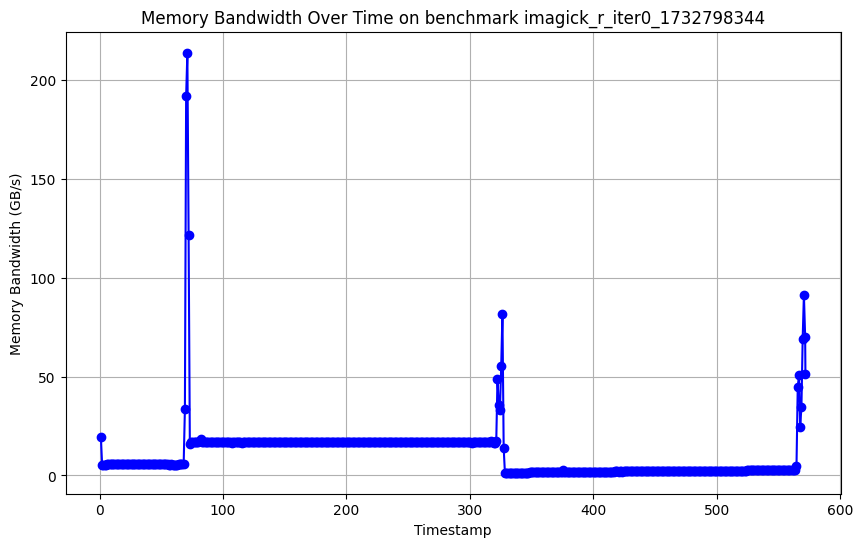

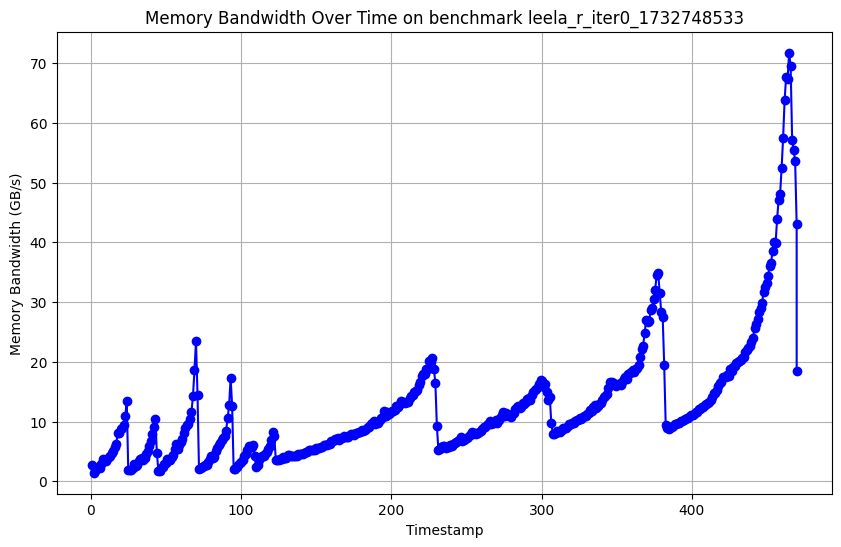

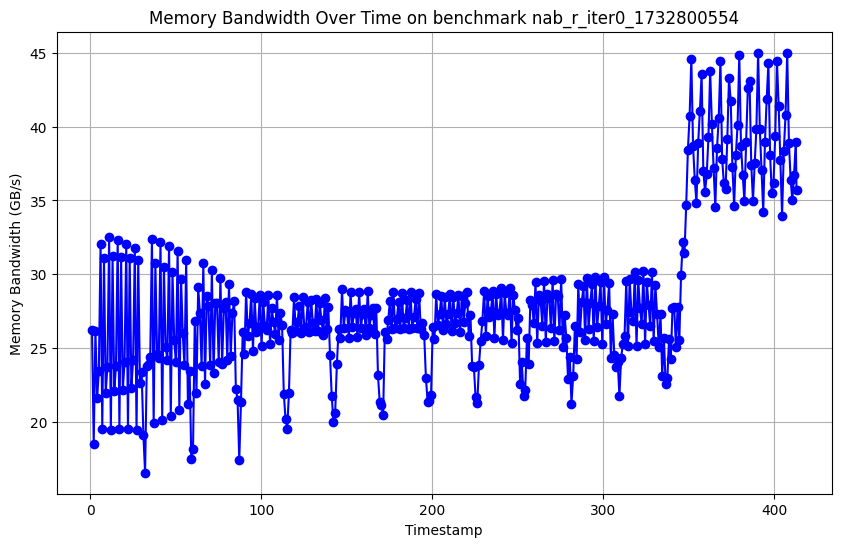

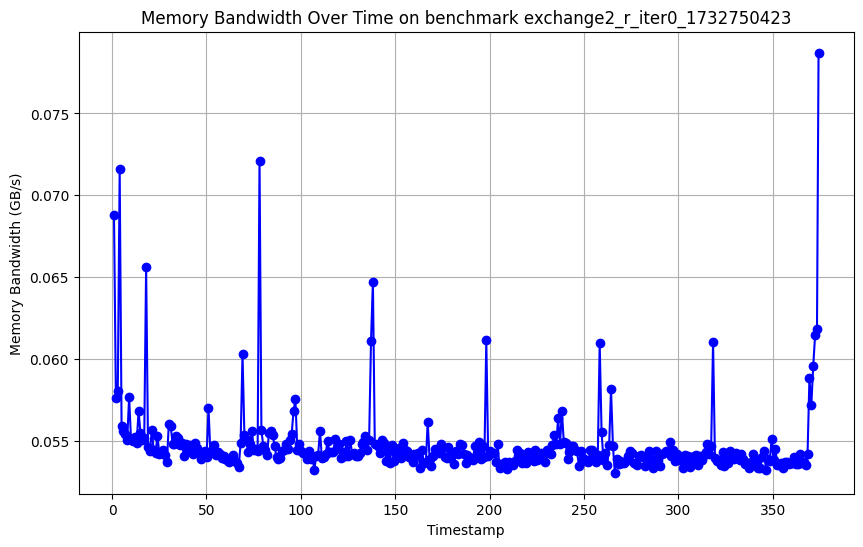

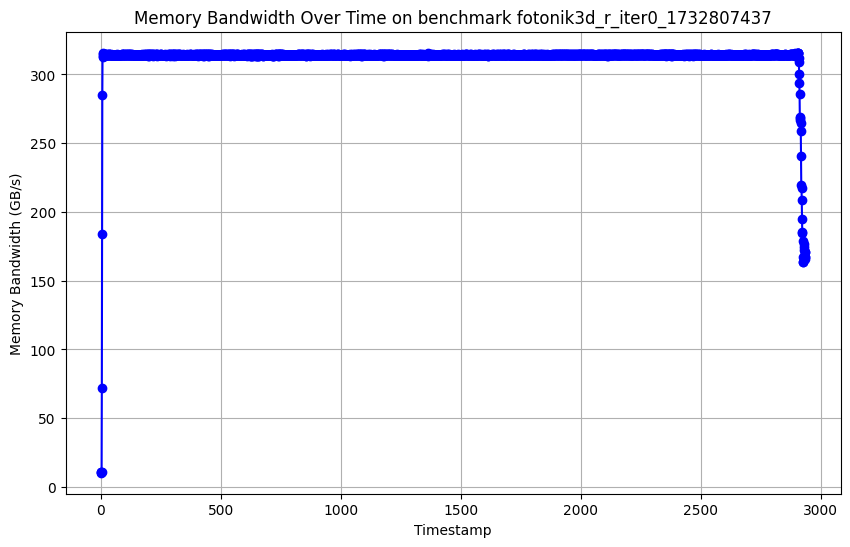

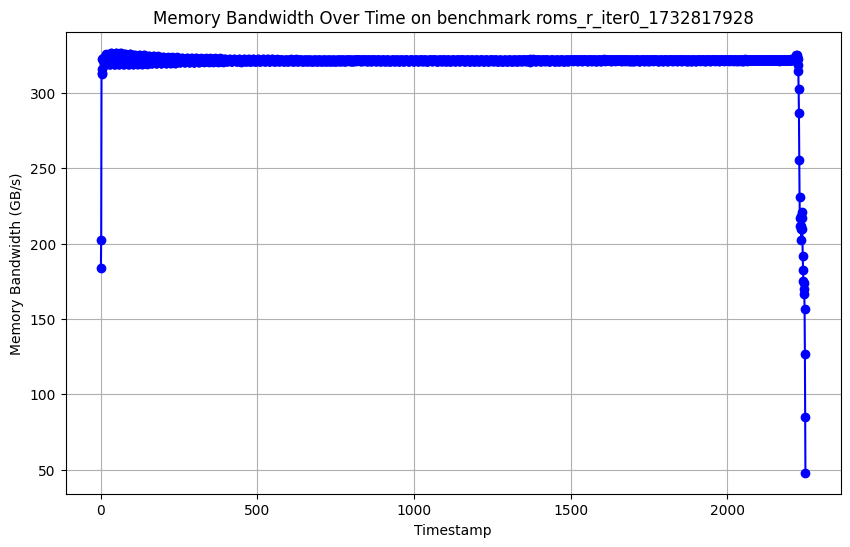

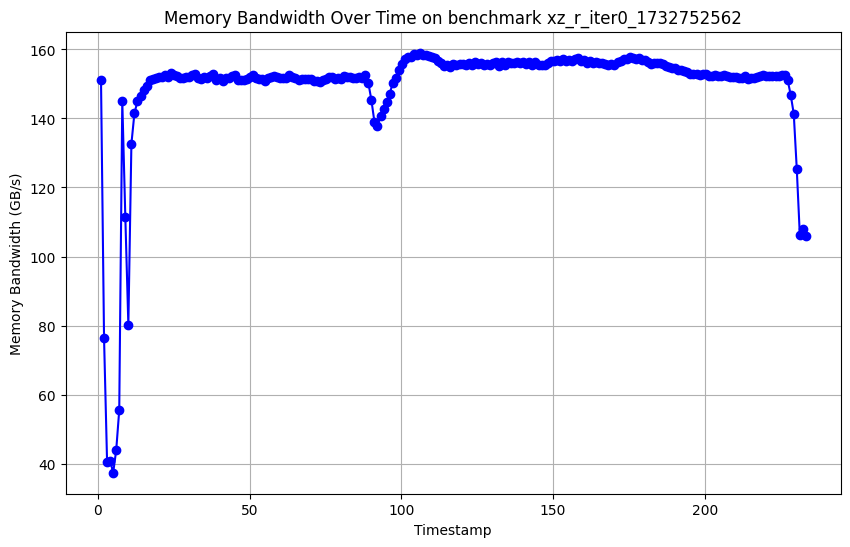

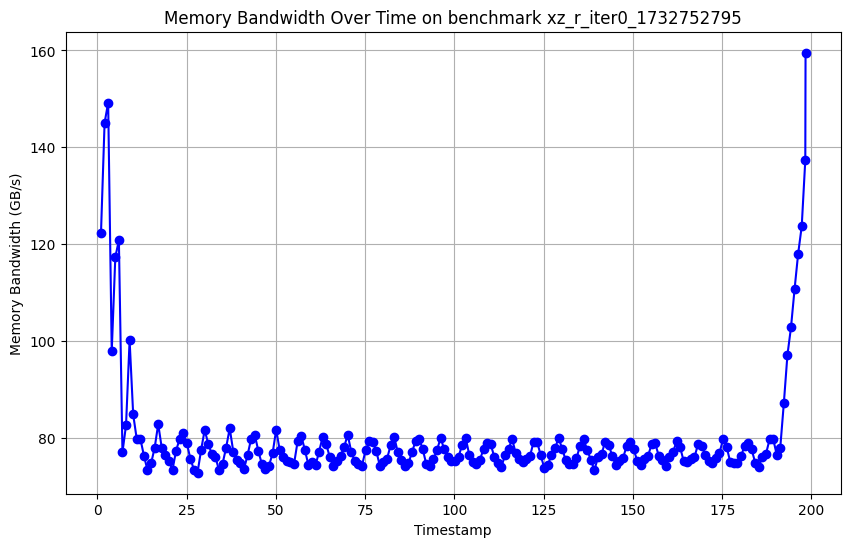

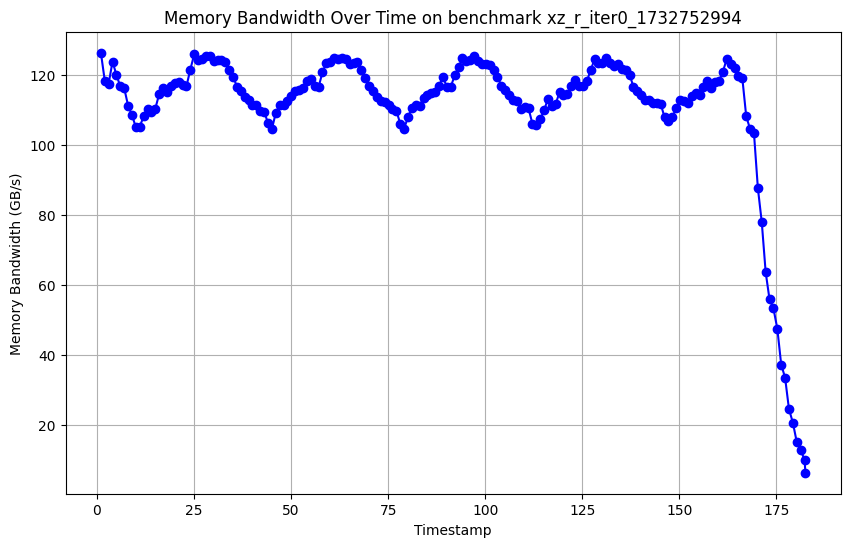

In [ ]:
# 存放实时带宽曲线图的目录
image_dir = "../data/images/cmn_mc/"


for data_csv in files:
    perf_raw_path = csv_dir + data_csv
    perf_raw_data = pd.read_csv(perf_raw_path,
                                sep='|',
                                header=None, 
                                names=["timestamp", "value", "event"], 
                                usecols=[0, 1, 3])
    
    
    perf_raw_data['type'] = perf_raw_data['event'].apply(
        lambda x: 'reqs' if 'reqs'in x else 'retries'
    )
    perf_raw_data['socket'] = perf_raw_data['event'].apply(
        lambda x: 0 if x[8] == '0' else '1'
    )
    perf_raw_data = perf_raw_data.drop('event', axis=1)

    perf_raw_data.loc[perf_raw_data["type"] == "retries", "value"] *= -1

    
    bw_all = perf_raw_data.groupby(['timestamp']).agg(value=('value', 'sum')).reset_index()

    bw_all['interval'] = bw_all['timestamp'].diff()
    bw_all.loc[0, 'interval'] = bw_all.loc[0, 'timestamp']

    bw_all['memory bandwidth (GB/s)'] = (bw_all['value'] * 64) / (bw_all['interval'] * 1000000000)


    plt.figure(figsize=(10, 6))
    plt.plot(bw_all['timestamp'], bw_all['memory bandwidth (GB/s)'], marker='o', linestyle='-', color='b')
    plt.title('Memory Bandwidth Over Time on benchmark ' + data_csv.split(".")[1])
    plt.xlabel('Timestamp')
    plt.ylabel('Memory Bandwidth (GB/s)')
    plt.grid(True)
    plt.savefig(image_dir + f'{data_csv.split(".")[0] + "_" + data_csv.split(".")[1] + ".png"}')